In [2]:
!pip install -qq einops
!pip install -qq torchsummary

import os
import cv2

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from torch import Tensor
from torch.utils.data import Subset

from PIL import Image
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

# Dataset

In [3]:
class RetinopathyDataset(Dataset):
    def __init__(self, path, transform=None):
        self.img_paths = list(self.absolute_paths(path))
        self.transform = transform
        png_ext = '.png'
        self.paths = [p for p in self.img_paths if png_ext in p]
        self.df = pd.read_csv(path + 'train.csv')
        self.df = shuffle(self.df)
    
    def absolute_paths(self, directory):
        for dirpath,_,filenames in os.walk(directory):
            for f in filenames:
                yield os.path.abspath(os.path.join(dirpath, f))
                
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        id_code = self.df.iloc[idx].id_code
        diagnosis = self.df.iloc[idx].diagnosis
        
        img_path = [s for s in self.paths if id_code in s][0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, diagnosis

In [4]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=224),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [5]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [6]:
path = '../input/diabetic-retinopathy-224x224-gaussian-filtered/'

rds_train = RetinopathyDataset(path, train_transform)
rds_val = RetinopathyDataset(path, val_transform)

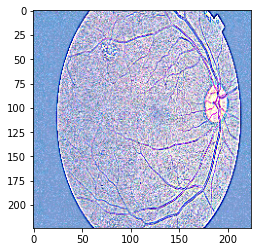

In [7]:
plt.imshow(rds_train[0][0].permute(1, 2, 0))

In [8]:
train_idx, valid_idx = train_test_split(np.arange(len(rds_train)), shuffle=False,
                                                    test_size=0.3, random_state=42)

In [9]:
train_subset = Subset(rds_train, train_idx)
valid_subset = Subset(rds_val, valid_idx)

In [10]:
train_loader = DataLoader(train_subset, batch_size=8,
                          shuffle=True, num_workers=0)

valid_loader = DataLoader(valid_subset, batch_size=8,
                          shuffle=True, num_workers=0)

# Architecture

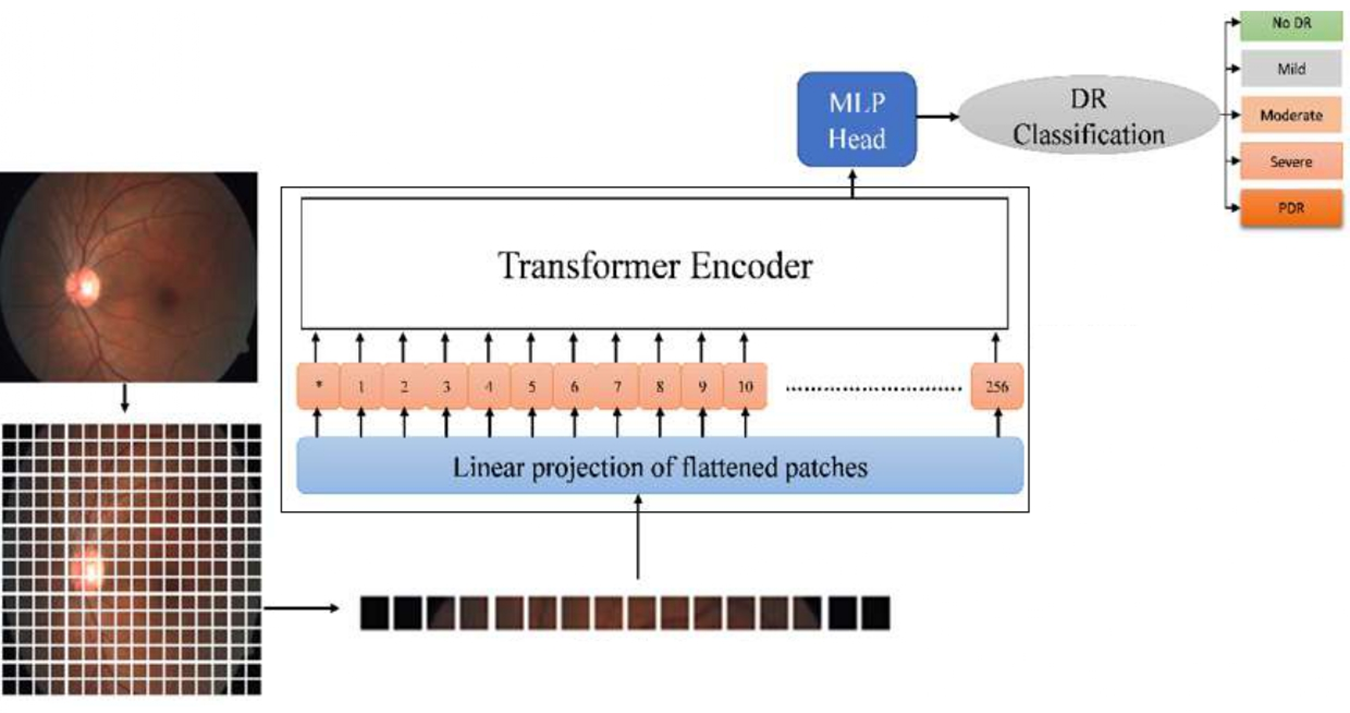

# Implementation

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, 
                 emb_size: int=768, img_size: int=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, 
                      kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(
                         torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=8, dropout: float=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), 
                        "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        # batch, num_heads, query_len, key_len
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [13]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [14]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int=4, drop_p: float=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [15]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [16]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [17]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [18]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 5,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

# Training

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = ViT().to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [21]:
epochs = 100

epoch_losses = np.zeros((epochs, len(train_loader)))
epoch_accuracies = np.zeros((epochs, len(train_loader)))

epoch_val_losses = np.zeros((epochs, len(valid_loader)))
epoch_val_accuracies = np.zeros((epochs, len(valid_loader)))

for epoch in range(epochs):
    
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracies[epoch][i] = acc
        
        epoch_loss = loss / len(data)
        epoch_losses[epoch][i] = epoch_loss
        
    with torch.no_grad():

        for i, (data, label) in enumerate(valid_loader):
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output, label)
            
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracies[epoch][i] = acc
            
            epoch_val_loss = val_loss / len(data)
            epoch_val_losses[epoch][i] = epoch_val_loss
           
    if((epoch+1) % 10 == 0):
        print("Epoch:{:3d}, loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}"
              .format(epoch, epoch_losses[epoch].mean(), 
                      epoch_accuracies[epoch].mean(), 
                      epoch_val_losses[epoch].mean(), 
                      epoch_val_accuracies[epoch].mean()))

Epoch:  9, loss:0.1115, acc:0.6828, val_loss:0.0985, val_acc:0.7123
Epoch: 19, loss:0.1051, acc:0.6886, val_loss:0.0934, val_acc:0.7132
Epoch: 29, loss:0.1022, acc:0.7013, val_loss:0.0921, val_acc:0.7195
Epoch: 39, loss:0.1023, acc:0.6985, val_loss:0.0886, val_acc:0.7310
Epoch: 49, loss:0.1001, acc:0.7076, val_loss:0.0882, val_acc:0.7283
Epoch: 59, loss:0.0990, acc:0.7105, val_loss:0.0873, val_acc:0.7313
Epoch: 69, loss:0.0987, acc:0.7061, val_loss:0.0874, val_acc:0.7394
Epoch: 79, loss:0.0949, acc:0.7221, val_loss:0.0869, val_acc:0.7370
Epoch: 89, loss:0.0948, acc:0.7200, val_loss:0.0847, val_acc:0.7373
Epoch: 99, loss:0.0948, acc:0.7138, val_loss:0.0833, val_acc:0.7379


In [22]:
(output.argmax(dim=1) == label).float().mean()

tensor(0., device='cuda:0')

# Analyze

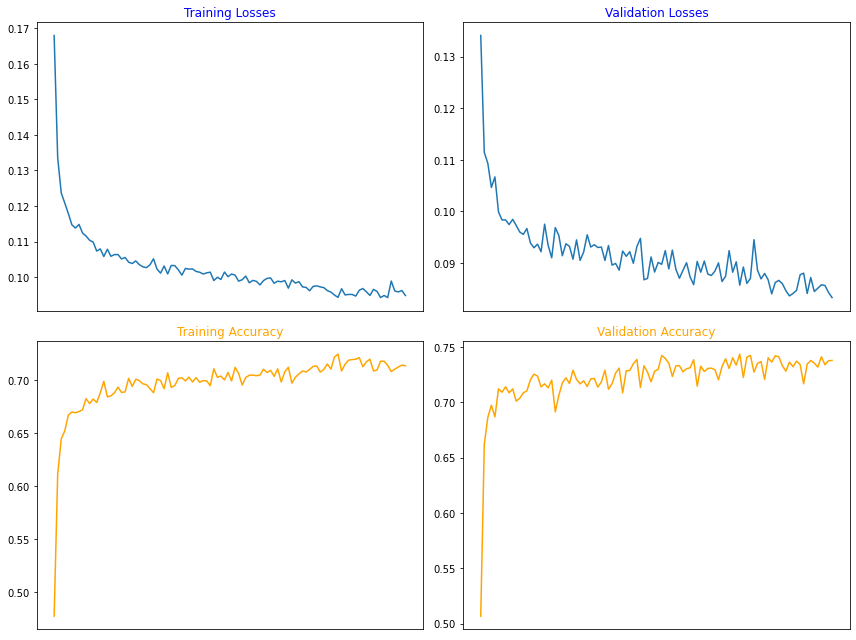

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
axes[0,0].set_title('Training Losses', color='blue')
axes[0,0].plot(epoch_losses.mean(axis=1))
axes[0,0].axes.get_xaxis().set_visible(False)
axes[0,1].set_title('Validation Losses', color='blue')
axes[0,1].plot(epoch_val_losses.mean(axis=1))
axes[0,1].axes.get_xaxis().set_visible(False)
axes[1,0].set_title('Training Accuracy', color='orange')
axes[1,0].plot(epoch_accuracies.mean(axis=1), color='orange')
axes[1,0].axes.get_xaxis().set_visible(False)
axes[1,1].set_title('Validation Accuracy', color='orange')
axes[1,1].plot(epoch_val_accuracies.mean(axis=1), color='orange')
axes[1,1].axes.get_xaxis().set_visible(False)
fig.tight_layout()

# Predict

In [24]:
def predict(image, device):
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
        
    label = model(image.to(device))
    label_max = torch.max(label, axis=1)[1].item()
    return label_max

In [25]:
# try 10 images
for i in range(10):
    image, label = rds_val[i]
    
    predicted = predict(image, device)
    expected = label
    correct = expected==predicted
    
    print('{:2d}) Expected:{:1d} - Predicted:{:1d} - Correct:{}'
             .format(i+1, expected, predicted, correct))

 1) Expected:0 - Predicted:0 - Correct:True
 2) Expected:0 - Predicted:0 - Correct:True
 3) Expected:2 - Predicted:1 - Correct:False
 4) Expected:0 - Predicted:0 - Correct:True
 5) Expected:0 - Predicted:0 - Correct:True
 6) Expected:0 - Predicted:0 - Correct:True
 7) Expected:2 - Predicted:2 - Correct:True
 8) Expected:2 - Predicted:0 - Correct:False
 9) Expected:2 - Predicted:1 - Correct:False
10) Expected:0 - Predicted:0 - Correct:True


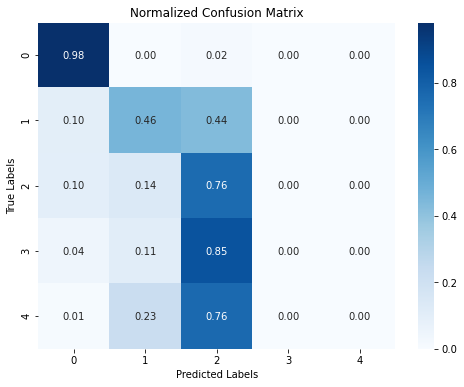

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store predictions and actual labels
all_preds = []
all_labels = []

# Iterate through the test set
for i, (data, label) in enumerate(valid_loader):
    data = data.to(device)
    label = label.to(device)
    
    # Make predictions
    output = model(data)
    preds = output.argmax(dim=1)
    
    # Append predictions and labels
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(label.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix by row (i.e., true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [42]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds)
print(report)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95       555
           1       0.44      0.46      0.45       117
           2       0.55      0.76      0.64       284
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        97

    accuracy                           0.74      1099
   macro avg       0.38      0.44      0.41      1099
weighted avg       0.66      0.74      0.69      1099



In [50]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert labels and predictions to numpy arrays
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

In [51]:
# Get model probabilities for ROC and PRC
all_probs = []

model.eval()
with torch.no_grad():
    for data, label in valid_loader:
        data = data.to(device)
        output = model(data)
        probs = torch.softmax(output, dim=1)
        all_probs.append(probs.cpu().numpy())
all_probs = np.concatenate(all_probs, axis=0)

# Binarize labels for multiclass ROC/PRC
n_classes = len(np.unique(all_labels_np))
all_labels_bin = label_binarize(all_labels_np, classes=list(range(n_classes)))

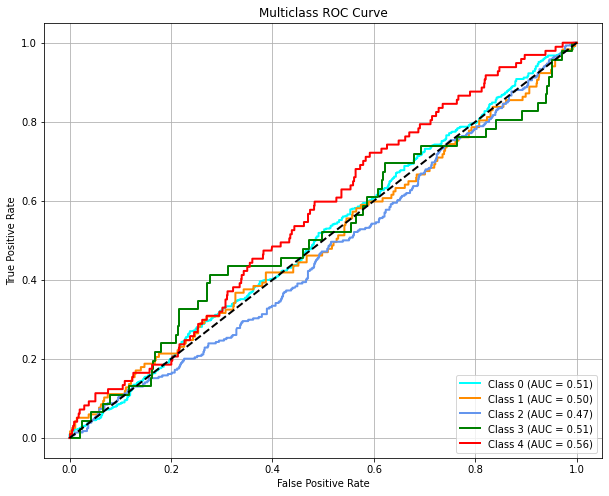

In [52]:
# ====================== ROC Curve ======================
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()    

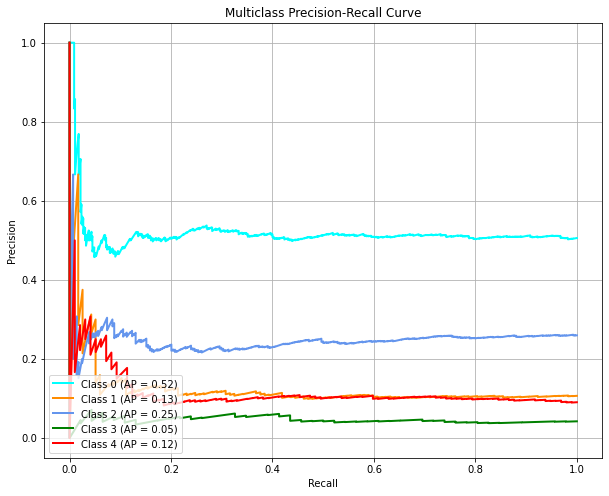

In [53]:
# =================== Precision-Recall Curve ====================
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
    average_precision[i] = average_precision_score(all_labels_bin[:, i], all_probs[:, i])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:0.2f})')

plt.title('Multiclass Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid()
plt.show()    

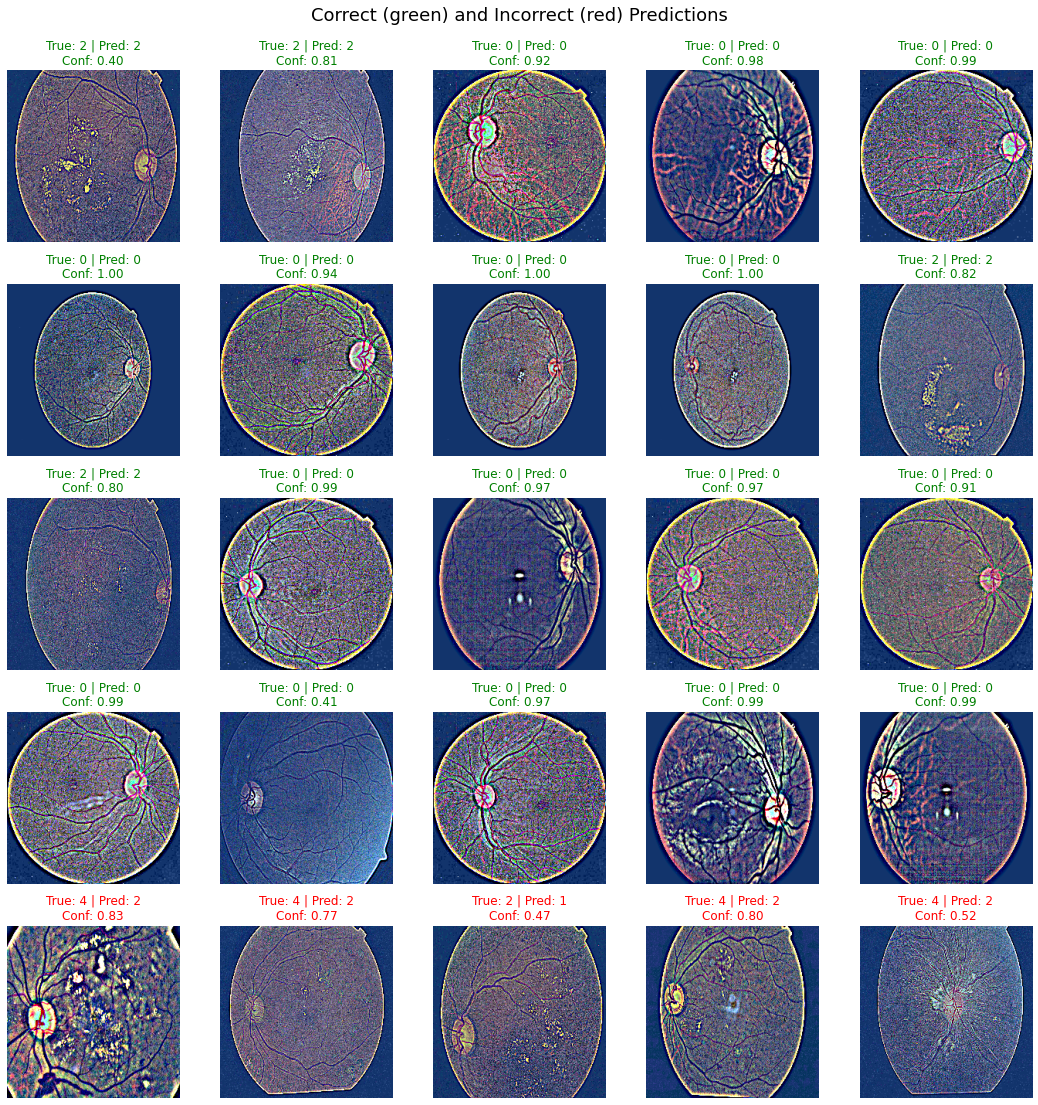

In [56]:
import matplotlib.pyplot as plt

# Desired number of correct and incorrect examples
num_correct_to_show = 20
num_wrong_to_show = 5

correct_images, wrong_images = [], []
correct_labels, wrong_labels = [], []
correct_preds, wrong_preds = [], []
correct_confs, wrong_confs = [], []

model.eval()
with torch.no_grad():
    for data, labels in valid_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        for i in range(len(labels)):
            image = data[i].cpu()
            pred = preds[i].item()
            true = labels[i].item()
            conf = probs[i][pred].item()

            if pred == true and len(correct_images) < num_correct_to_show:
                correct_images.append(image)
                correct_preds.append(pred)
                correct_labels.append(true)
                correct_confs.append(conf)
            elif pred != true and len(wrong_images) < num_wrong_to_show:
                wrong_images.append(image)
                wrong_preds.append(pred)
                wrong_labels.append(true)
                wrong_confs.append(conf)

        # Stop once we have enough of both
        if len(correct_images) >= num_correct_to_show and len(wrong_images) >= num_wrong_to_show:
            break

# Combine for display
all_images = correct_images + wrong_images
all_preds = correct_preds + wrong_preds
all_labels = correct_labels + wrong_labels
all_confs = correct_confs + wrong_confs
all_colors = ["green"] * num_correct_to_show + ["red"] * num_wrong_to_show

# Plot
total = num_correct_to_show + num_wrong_to_show
rows = int(total ** 0.5)
cols = int(np.ceil(total / rows))

plt.figure(figsize=(cols * 3, rows * 3))
for idx in range(total):
    img = all_images[idx].permute(1, 2, 0).numpy()
    true = all_labels[idx]
    pred = all_preds[idx]
    conf = all_confs[idx]
    color = all_colors[idx]

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true} | Pred: {pred}\nConf: {conf:.2f}", color=color)

plt.tight_layout()
plt.suptitle("Correct (green) and Incorrect (red) Predictions", fontsize=18, y=1.02)
plt.show()